In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.29MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
from torch.utils.data import DataLoader

loaders = {
    'train' : DataLoader(train_data, batch_size = 100, shuffle = True, num_workers = 1),
    'test' : DataLoader(test_data, batch_size = 100, shuffle = True, num_workers = 1),
}

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)

    return F.softmax(x)

In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print(f"Train Epoch : {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item() :.6f}")

def test():
  model.eval()

  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim = 1, keepdim = True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(loaders['test'].dataset)
  print(f"\nTest Set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")

In [10]:
for epoch in range(1,11):
  train(epoch)
  test()

<ipython-input-8-319b49ac7778>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch : 1 [0/60000 (0%)]	2.302605
Train Epoch : 1 [2000/60000 (3%)]	2.292365
Train Epoch : 1 [4000/60000 (7%)]	2.158916
Train Epoch : 1 [6000/60000 (10%)]	1.986609
Train Epoch : 1 [8000/60000 (13%)]	1.899865
Train Epoch : 1 [10000/60000 (17%)]	1.871595
Train Epoch : 1 [12000/60000 (20%)]	1.781731
Train Epoch : 1 [14000/60000 (23%)]	1.825837
Train Epoch : 1 [16000/60000 (27%)]	1.787958
Train Epoch : 1 [18000/60000 (30%)]	1.733970
Train Epoch : 1 [20000/60000 (33%)]	1.691231
Train Epoch : 1 [22000/60000 (37%)]	1.690805
Train Epoch : 1 [24000/60000 (40%)]	1.676899
Train Epoch : 1 [26000/60000 (43%)]	1.627761
Train Epoch : 1 [28000/60000 (47%)]	1.622308
Train Epoch : 1 [30000/60000 (50%)]	1.630815
Train Epoch : 1 [32000/60000 (53%)]	1.632214
Train Epoch : 1 [34000/60000 (57%)]	1.721830
Train Epoch : 1 [36000/60000 (60%)]	1.604851
Train Epoch : 1 [38000/60000 (63%)]	1.612027
Train Epoch : 1 [40000/60000 (67%)]	1.652532
Train Epoch : 1 [42000/60000 (70%)]	1.637983
Train Epoch : 1 [4400

In [11]:
device

device(type='cpu')

Prediction: 2


<ipython-input-8-319b49ac7778>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


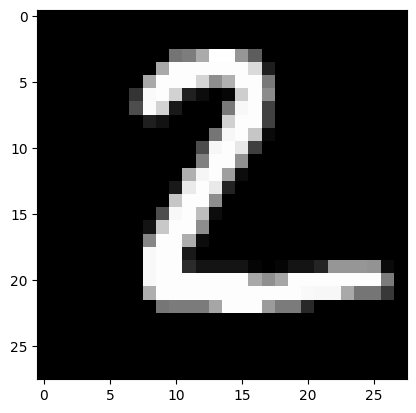

In [13]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[1]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim = 1, keepdim = True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap = 'gray')
plt.show()


In [17]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in loaders['test']:
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.tolist())
        if isinstance(target, torch.Tensor):
            all_targets.extend(target.cpu().tolist())
        else:
            all_targets.append(target)
accuracy = accuracy_score(all_targets, all_preds)
print(f"Model Accuracy: {accuracy * 100:.2f}%")



<ipython-input-8-319b49ac7778>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Model Accuracy: 97.41%
